In [51]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [52]:
df = pd.read_csv('../final_merge.csv')

In [53]:
df.shape

(1007807, 35)

In [54]:
df.columns

Index(['Unnamed: 0', 'song_hotttnesss', 'song_id', 'artist_latitude',
       'artist_location', 'artist_longitude', 'track_id', 'loudness_x',
       'mode_x', 'tempo_x', 'key_x', 'genre1_cd2c', 'genre2_cd2c',
       'genre1_cd2', 'genre2_cd2', 'genre1_cd1', 'genre2_cd1', 'artist_id',
       'duration', 'artist_hotttnesss', 'year', 'danceability', 'energy',
       'key_y', 'loudness_y', 'mode_y', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo_y', 'duration_ms',
       'track_popularity', 'album_release'],
      dtype='object')

In [55]:
df.columns.values[0] = 'id'
df.head()

,id,song_hotttnesss,song_id,artist_latitude,artist_location,artist_longitude,track_id,loudness_x,mode_x,tempo_x,...,mode_y,speechiness,acousticness,instrumentalness,liveness,valence,tempo_y,duration_ms,track_popularity,album_release
0,0,0.542899,SOQMMHC12AB0180CB8,NaN,NaN,NaN,TRMMMYQ128F932D901,-4.829,0,87.002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.299877,SOVFVAK12A8C1350D9,NaN,NaN,NaN,TRMMMKD128F425225D,-10.555,1,150.778,...,1.0,0.0462,0.002230,0.090,0.0869,0.880,149.971,157933.0,1.0,1995.0
2,2,0.617871,SOGTUKN12AB017F4F1,55.8578,"Glasgow, Scotland",-4.24251,TRMMMRX128F93187D9,-2.060,1,177.768,...,NaN,0.0662,0.000045,0.952,0.3430,0.621,177.745,138960.0,18.0,2009.0
3,3,NaN,SOBNYVR12A8C13558C,NaN,NaN,NaN,TRMMMCH128F425532C,-4.654,1,87.433,...,1.0,0.1470,0.130000,NaN,0.1150,0.962,174.013,145032.0,0.0,2003.0
4,4,NaN,SOHSBXH12A8C13B0DF,NaN,NaN,NaN,TRMMMWA128F426B589,-7.806,0,140.035,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
df2 = df[(pd.isnull(df.genre1_cd1) == False) | (pd.isnull(df.genre1_cd2) == False) | (pd.isnull(df.genre1_cd2c) == False)].copy()

In [57]:
df2_year = df2.groupby(['year']).size().reset_index(name='counts')

First we check the number of song per year we have in the dataset. As expected we see an increase in the number of songs over the year except for 2010, this is probably because the year 2010 was just ending when the dataset was created and the 2010 songs hadn't had the time to attain their maximum popularity.

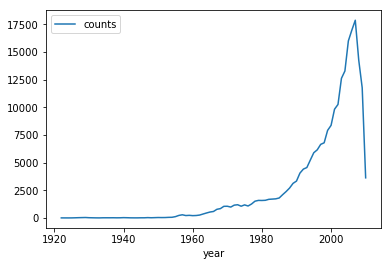

In [58]:
df2_year.iloc[1:, :].plot(x='year', y='counts', kind='line')

As we can see there is not a lot of songs before 60's, thus we will drop this song to continues a meaningful analysis.

In [59]:
df2 = df2[df2.year > 1960]

In [60]:
genres = set([])
genres_cols = ['genre1_cd2c', 'genre2_cd2c', 'genre1_cd2', 'genre2_cd2', 'genre1_cd1', 'genre2_cd1']
for col_name in genres_cols:
    genres = genres | set(df2[col_name].unique())
print(genres)
print(len(genres))

{nan, nan, 'Blues', 'Folk', 'International', 'Rock', 'Vocal', 'Metal', 'RnB', 'Country', 'Jazz', 'Punk', 'Reggae', 'Electronic', 'Latin', 'World', 'Pop', 'Rap', 'New Age', 'Pop_Rock'}
20


We have 17 different genres (nan are unkownn and international is the same as world). To do a meaningful analysis of the genre analysis over the year a minimum amount of songs of the analyzed type must be in the dataset. In the following cells we first replace the nan and replace International by World. 

In [61]:
df2[genres_cols] = df2[genres_cols].fillna('Unknown')
df2[genres_cols] = df2[genres_cols].replace('International', 'World')

In [62]:
genres = set([])
genres_cols = ['genre1_cd2c', 'genre2_cd2c', 'genre1_cd2', 'genre2_cd2', 'genre1_cd1', 'genre2_cd1']
for col_name in genres_cols:
    genres = genres | set(df2[col_name].unique())
    df2[col_name] = df2[col_name].astype(str)
print(genres)
print(len(genres))

{'Blues', 'Folk', 'Rock', 'Vocal', 'Metal', 'RnB', 'Country', 'Jazz', 'Punk', 'Reggae', 'Electronic', 'Latin', 'Unknown', 'Pop', 'World', 'Rap', 'New Age', 'Pop_Rock'}
18


In [63]:
df2[genres_cols].head()

,genre1_cd2c,genre2_cd2c,genre1_cd2,genre2_cd2,genre1_cd1,genre2_cd1
2,Unknown,Unknown,Electronic,Rap,Electronic,Rap
11,Latin,Unknown,Latin,Unknown,Unknown,Unknown
15,Pop,Unknown,Pop,Unknown,Unknown,Unknown
17,Unknown,Unknown,Rock,Metal,Unknown,Unknown
18,Rock,Unknown,Rock,Unknown,Unknown,Unknown


For the moment we have 6 columns for the genres, we would like to see if we can summarize these columns in one or two columns.
First we perform a pivot and count the number of different values there are in each column. 

In [64]:
for genre in list(genres):
    df2[genre] = 0
    for col_name in genres_cols:
        df2.loc[df2[col_name] == genre, genre] = 1
df2 = df2.drop(columns=['Unknown'])
genres.remove('Unknown')

In [65]:
df2['nb_genre'] = np.sum(df2.iloc[:, -17:].values, axis=1)

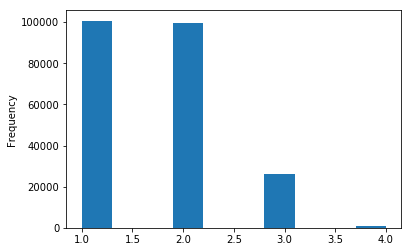

In [66]:
df2['nb_genre'].plot(kind='hist')

So we see that the majority of the songs have 1 or 2 different genres, some also have 3 genres and 4 genres is atypical. We can now drop the 6 columns containing the label genres.

In [67]:
df2 = df2.drop(columns=genres_cols)

Now for each genre we plot the number of sample per year.

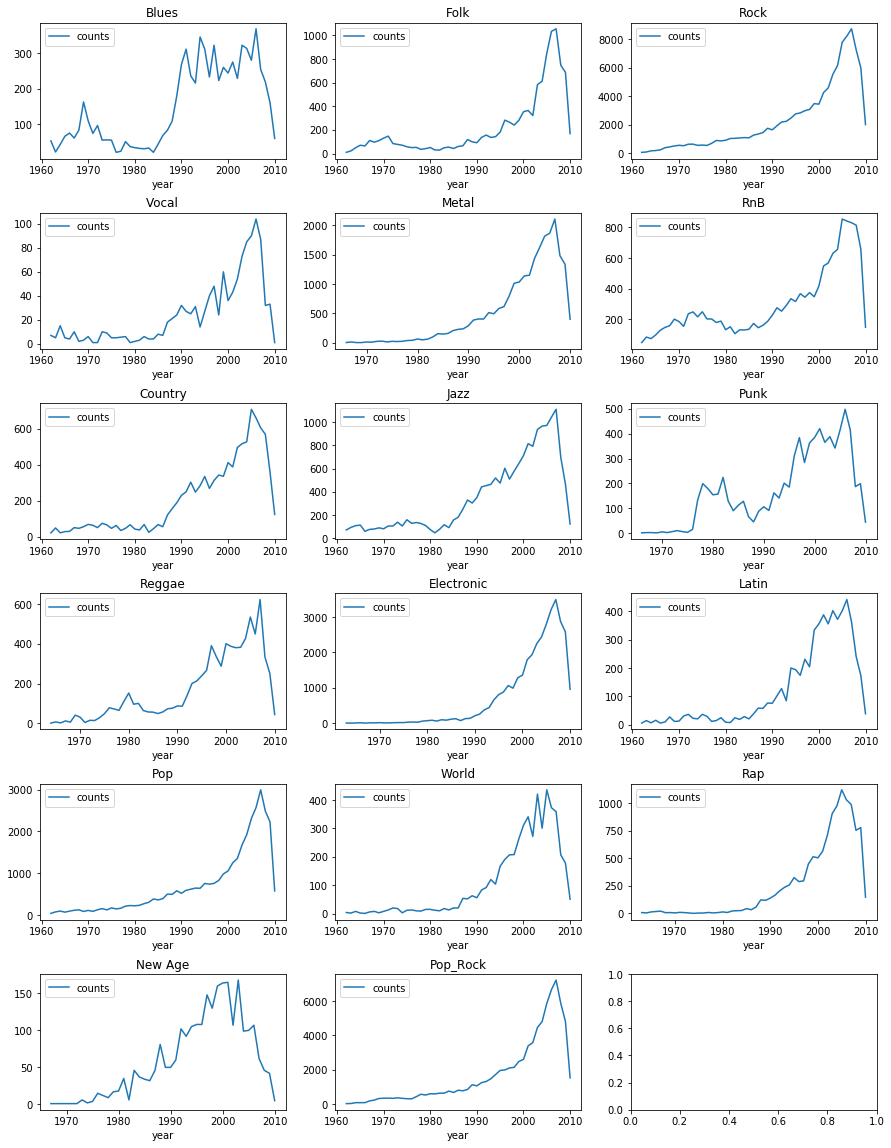

In [107]:
int(len(list(genres))/3.0 + .5)
f, axarr = plt.subplots(int(len(list(genres))/3.0 + .5), 3)
f.set_size_inches(15, 20)
plt.subplots_adjust(hspace=.4)
i = 0
for genre in genres:
    df2[df2[genre] == 1].groupby(['year']).size().reset_index(name='counts').iloc[1:, :]\
    .plot(x='year', y='counts', kind='line', title=genre, ax=axarr[int(i/3), i%3])
    fig = axarr[int(i/3), i%3].get_figure()
    extent = axarr[int(i/3), i%3].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('figures/%s_distri_year.png' % (genre), bbox_inches=extent.expanded(1.25, 1.2), dpi = 500)
    i+=1

These plots are useful to see the data we have in our hands. 

Firstly we observe that most of the music we have is rock, pop, pop_rock, electronic or metal. On the opposite World, Latin, blues are not very represented. This can be explained whether because the dataset is biased but also because some genre are more popular. Indeed Latin music is sub-represented although there is a very important latin culture in the world. These observations could be made more precise by using only the total number of songs for each genre.

Secondly these plots enable us to see some trends in the evolution of the music. If we suppose the dataset is not too much biased for the genre the most represented we can make some interesting observations. We can see that punk music suddenly appears in the middle of the 70's. Rock started in the 60's and grows exponentially since this moment. Indeed these plots are useful to tell something about when the genre appears and how it has evolved since this moment. 

Now we want to look how genre are connected, so let's construct a graph in which nodes are the genre and connection between genre appears when a song has both genres. The weight of the connection is given by the number of songs.

In [69]:
adj_mat_genres = np.zeros([len(genres), len(genres)])
genres = list(genres)
for i in range(len(genres)):
    for j in range(i, len(genres)):
        nb_songs = df2[(df2[genres[i]] == 1) & (df2[genres[j]] == 1)].shape[0]
        adj_mat_genres[i, j] = nb_songs
        adj_mat_genres[j, i] = nb_songs

adj_mat_genres

In [70]:
adj_df = pd.DataFrame(adj_mat_genres, columns=genres)

In [71]:
adj_df['genre'] = genres

In [72]:
adj_df['radius'] = (np.diag(adj_mat_genres))**.5
adj_df['id'] = range(len(adj_df))

In [73]:
adj_df[['radius', 'id', 'genre']].T.to_dict().values()

dict_values([{'radius': 85.32877591996736, 'genre': 'Blues', 'id': 0}, {'radius': 102.73266277090262, 'genre': 'Folk', 'id': 1}, {'radius': 331.7755265235819, 'genre': 'Rock', 'id': 2}, {'radius': 34.044089061098404, 'genre': 'Vocal', 'id': 3}, {'radius': 150.03666218628032, 'genre': 'Metal', 'id': 4}, {'radius': 120.96280420029953, 'genre': 'RnB', 'id': 5}, {'radius': 99.7997995989972, 'genre': 'Country', 'id': 6}, {'radius': 131.51805959639154, 'genre': 'Jazz', 'id': 7}, {'radius': 87.39565206576354, 'genre': 'Punk', 'id': 8}, {'radius': 88.12491134747314, 'genre': 'Reggae', 'id': 9}, {'radius': 184.0135864549137, 'genre': 'Electronic', 'id': 10}, {'radius': 76.94153624668537, 'genre': 'Latin', 'id': 11}, {'radius': 182.94261395311918, 'genre': 'Pop', 'id': 12}, {'radius': 71.9444229944198, 'genre': 'World', 'id': 13}, {'radius': 109.38921336219582, 'genre': 'Rap', 'id': 14}, {'radius': 50.80354318352215, 'genre': 'New Age', 'id': 15}, {'radius': 283.6652957272003, 'genre': 'Pop_Rock

In [74]:
import json
a = adj_df[['radius', 'id', 'genre']].T.to_dict().values()
list(a)

[{'genre': 'Blues', 'id': 0, 'radius': 85.32877591996736},
 {'genre': 'Folk', 'id': 1, 'radius': 102.73266277090262},
 {'genre': 'Rock', 'id': 2, 'radius': 331.7755265235819},
 {'genre': 'Vocal', 'id': 3, 'radius': 34.044089061098404},
 {'genre': 'Metal', 'id': 4, 'radius': 150.03666218628032},
 {'genre': 'RnB', 'id': 5, 'radius': 120.96280420029953},
 {'genre': 'Country', 'id': 6, 'radius': 99.7997995989972},
 {'genre': 'Jazz', 'id': 7, 'radius': 131.51805959639154},
 {'genre': 'Punk', 'id': 8, 'radius': 87.39565206576354},
 {'genre': 'Reggae', 'id': 9, 'radius': 88.12491134747314},
 {'genre': 'Electronic', 'id': 10, 'radius': 184.0135864549137},
 {'genre': 'Latin', 'id': 11, 'radius': 76.94153624668537},
 {'genre': 'Pop', 'id': 12, 'radius': 182.94261395311918},
 {'genre': 'World', 'id': 13, 'radius': 71.9444229944198},
 {'genre': 'Rap', 'id': 14, 'radius': 109.38921336219582},
 {'genre': 'New Age', 'id': 15, 'radius': 50.80354318352215},
 {'genre': 'Pop_Rock', 'id': 16, 'radius': 28

In [75]:
adj_df = adj_df.iloc[:, :-3]

In [76]:
adj = adj_df.values

In [77]:
edges = []
for i in range(len(adj)):
    for j in range(i+1, len(adj)):
        edge = {'source_id': i, 'target_id': j, 'stroke_width': adj[i, j]/1000}
        edges.append(edge)
edges

[{'source_id': 0, 'stroke_width': 0.17399999999999999, 'target_id': 1},
 {'source_id': 0, 'stroke_width': 1.833, 'target_id': 2},
 {'source_id': 0, 'stroke_width': 0.0060000000000000001, 'target_id': 3},
 {'source_id': 0, 'stroke_width': 0.068000000000000005, 'target_id': 4},
 {'source_id': 0, 'stroke_width': 0.33900000000000002, 'target_id': 5},
 {'source_id': 0, 'stroke_width': 0.087999999999999995, 'target_id': 6},
 {'source_id': 0, 'stroke_width': 0.29699999999999999, 'target_id': 7},
 {'source_id': 0, 'stroke_width': 0.037999999999999999, 'target_id': 8},
 {'source_id': 0, 'stroke_width': 0.014, 'target_id': 9},
 {'source_id': 0, 'stroke_width': 0.10000000000000001, 'target_id': 10},
 {'source_id': 0, 'stroke_width': 0.02, 'target_id': 11},
 {'source_id': 0, 'stroke_width': 0.26400000000000001, 'target_id': 12},
 {'source_id': 0, 'stroke_width': 0.037999999999999999, 'target_id': 13},
 {'source_id': 0, 'stroke_width': 0.035000000000000003, 'target_id': 14},
 {'source_id': 0, 'stro

In [78]:
%%html
<iframe src="http://www.cbinge.com/file/test.html" width=1000 height = 1000/>

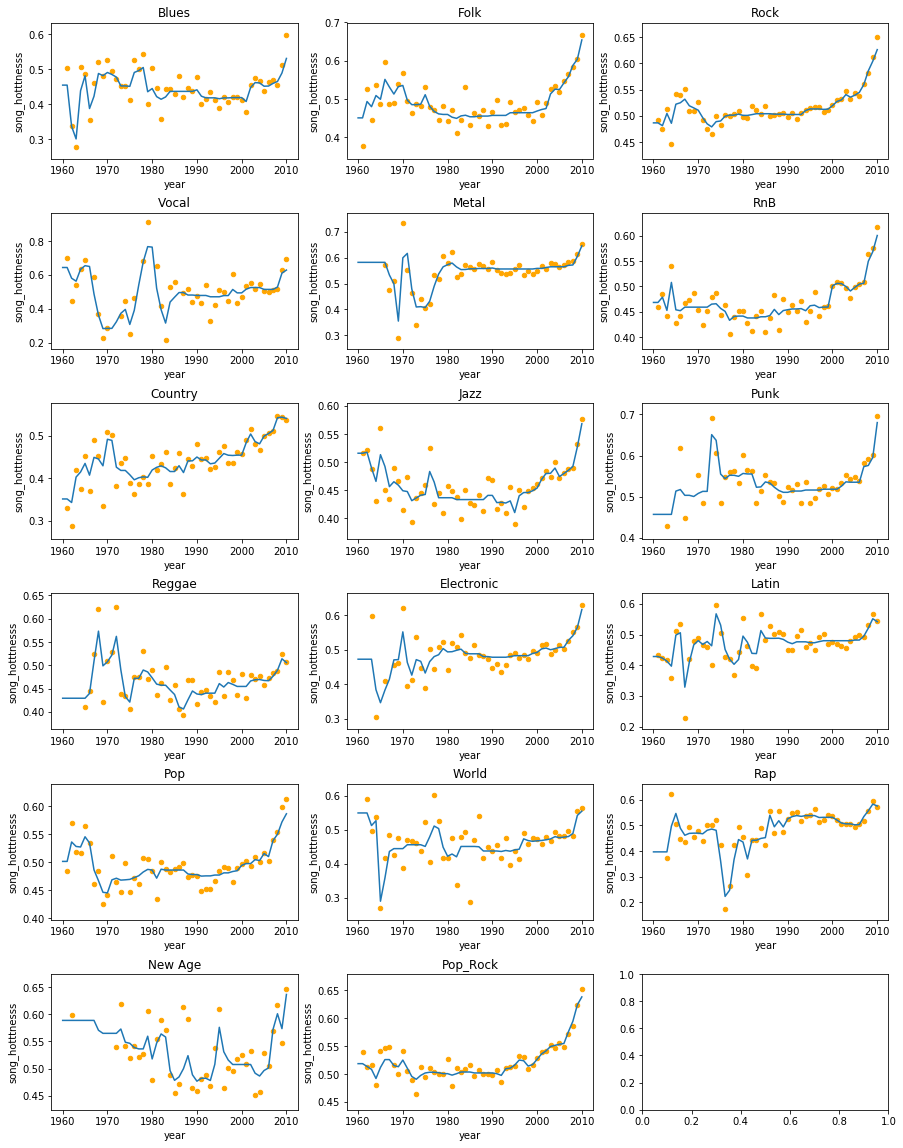

In [106]:
from sklearn.ensemble import RandomForestRegressor
int(len(list(genres))/3.0 + .5)
f, axarr = plt.subplots(int(len(list(genres))/3.0 + .5), 3)
f.set_size_inches(15, 20)
plt.subplots_adjust(hspace=.4)
i = 0
for genre in genres:
    regr = RandomForestRegressor(n_estimators=10, n_jobs=-1, max_depth= 5)
    hottness = df2[(df2[genre] == 1) & df2['song_hotttnesss'].notna()].groupby(['year']).mean().reset_index()
    hottness = hottness[hottness['song_hotttnesss'] > 0]
    regr.fit(hottness[['year']], hottness['song_hotttnesss'])
    hottness.plot(x='year', y='song_hotttnesss', kind='scatter', title=genre, ax=axarr[int(i/3), i%3], color='orange')
    hottness_predict = regr.predict(np.array(list(range(1960, 2011))).reshape(-1, 1))
    axarr[int(i/3), i%3].plot(list(range(1960, 2011)), hottness_predict)
    #print(hottness)
    #.reset_index(name='counts').iloc[1:, :]\
    #.plot(x='year', y='counts', kind='line', title=genre, ax=axarr[int(i/3), i%3])
    fig = axarr[int(i/3), i%3].get_figure()
    extent = axarr[int(i/3), i%3].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('figures/%s_hottness.png' % (genre), bbox_inches=extent.expanded(1.35, 1.4), dpi = 500)
    i+=1

# Milestone 3
### Analysis of the distribution of the different features for each genre
Look at the empirical probability function of the genre.
### Look at the influence of the year of these distribution
Is genre time invariant or not?
### Visualize the interesting results obtained
Visualization by using graph evolving with time.